In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


## DATASET

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize et ve uygun şekle sok
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


## NOISE

In [13]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


## DENOISING AUTOENCODER

In [14]:
input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


## TRAIN

In [15]:
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=10,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.2736 - val_loss: 0.1195
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1181 - val_loss: 0.1102
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.1103 - val_loss: 0.1061
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1064 - val_loss: 0.1036
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1043 - val_loss: 0.1021
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.1029 - val_loss: 0.1009
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1015 - val_loss: 0.0999
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.1005 - val_loss: 0.0994
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.1000 - val_loss: 0.0986
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0993 - val_loss: 0.0982


## PREDICT

In [16]:
decoded_imgs = autoencoder.predict(x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


## VISUALIZATION

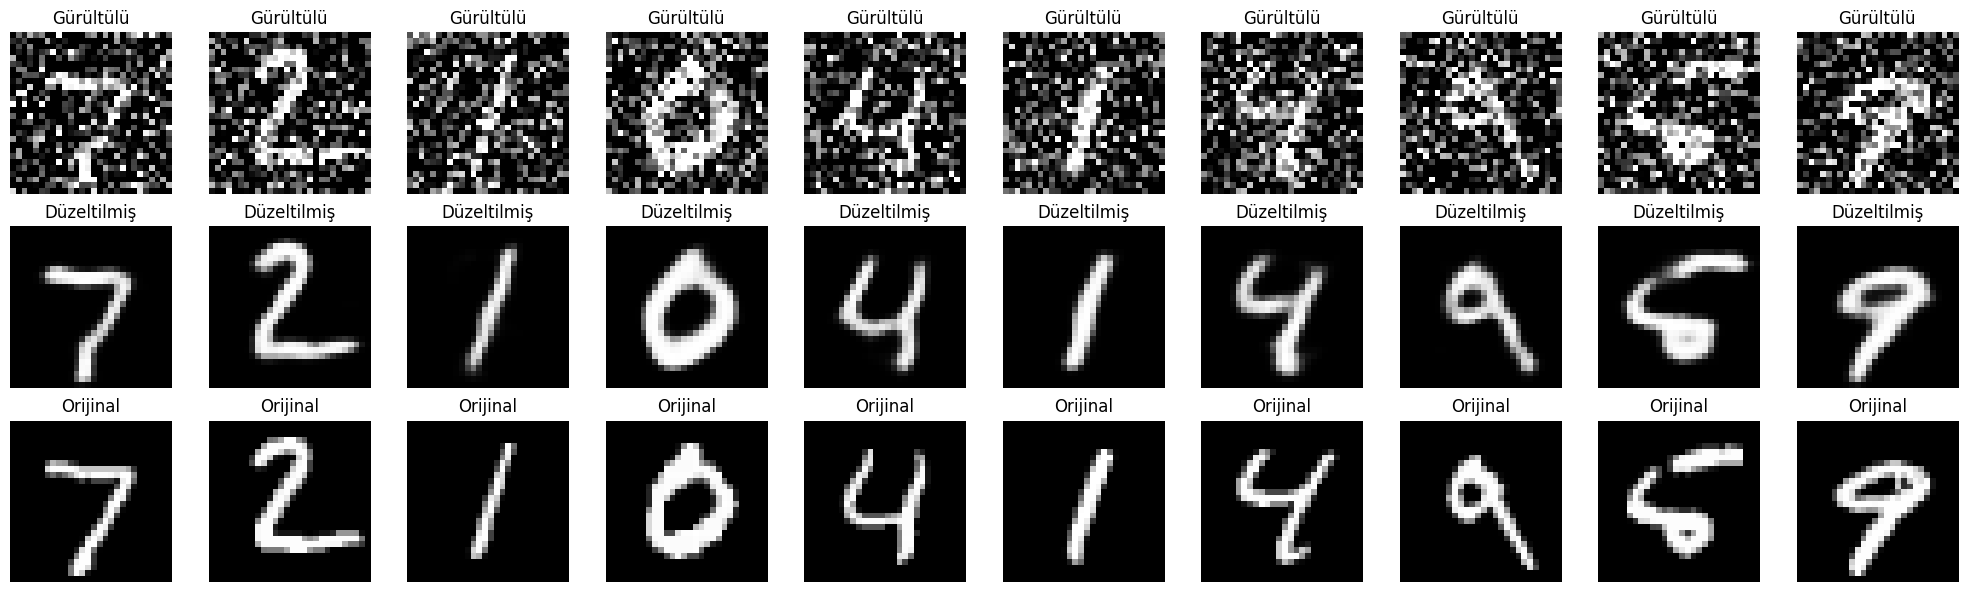

In [17]:
n = 10
plt.figure(figsize=(20, 6))

for i in range(n):
    # Gürültülü
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    plt.title("Gürültülü")
    plt.axis("off")

    # Temizlenmiş
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    plt.title("Düzeltilmiş")
    plt.axis("off")

    # Orijinal
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title("Orijinal")
    plt.axis("off")

plt.tight_layout()
plt.savefig("gorsel1.png")
plt.show()



## LOSS

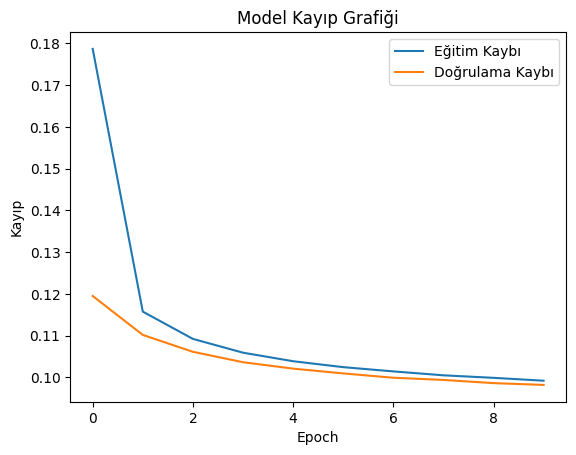

In [18]:
plt.figure()
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel("Epoch")
plt.ylabel("Kayıp")
plt.title("Model Kayıp Grafiği")
plt.legend()
plt.savefig("gorsel2.png")
plt.show()

## FEATURE EXTRACTION AND CLASSIFICATION

In [19]:
encoder = Model(inputs=autoencoder.input, outputs=encoded)
# Train ve test için ayrı encoder çıktısı al
encoded_train = encoder.predict(x_train_noisy)
features_train = encoded_train.reshape(encoded_train.shape[0], -1)

encoded_test = encoder.predict(x_test_noisy)
features_test = encoded_test.reshape(encoded_test.shape[0], -1)

# Lojistik regresyon ile sadece train verisiyle eğit
clf = LogisticRegression(max_iter=1000)
clf.fit(features_train, y_train)

# Test setiyle tahmin yap
y_pred = clf.predict(features_test)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


## REPORT

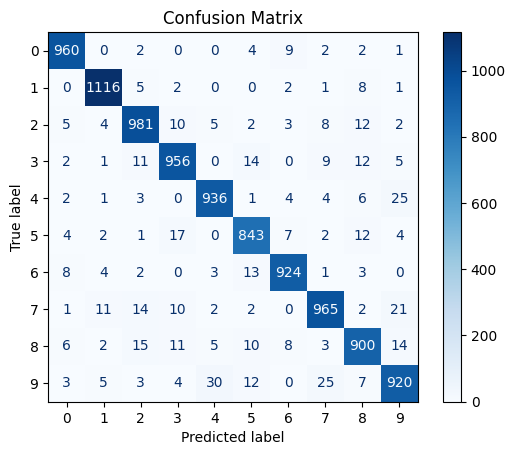

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.95      0.95       982
           5       0.94      0.95      0.94       892
           6       0.97      0.96      0.97       958
           7       0.95      0.94      0.94      1028
           8       0.93      0.92      0.93       974
           9       0.93      0.91      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [20]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("gorsel3.png")
plt.show()

print("Classification Report:\n")
print(classification_report(y_test, y_pred))
